In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display


gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0],True)

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

# BUFFER_SIZE = 60000
BATCH_SIZE = 256

EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 25

log_prefix = 'LSGAN'

save_name = f'{log_prefix}_Cifar10_ckpt'
checkpoint_dir = './weight/'+save_name

log_path = 'Log'
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BATCH_SIZE).batch(BATCH_SIZE)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
image_prefix = os.path.join('.','image',save_name)
os.makedirs(log_path,exist_ok=True)

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

def discriminator_loss(real_output, fake_output):
    real_loss = tf.losses.mean_squared_error(tf.ones_like(real_output), real_output)
    fake_loss = tf.losses.mean_squared_error(-1 * tf.ones_like(fake_output), fake_output)
    total_loss = ( real_loss + fake_loss ) / 2
    return total_loss

def generator_loss(fake_output):
    return tf.losses.mean_squared_error(tf.zeros_like(fake_output), fake_output) / 2

# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, \
    tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs, save_term = 50):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # 15 에포크가 지날 때마다 모델을 저장합니다.
        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        if (epoch + 1) % save_term == 0:
            generator.save_weights(
                    os.path.join(
                    checkpoint_dir, f'epoch-{epoch + 1}'
                )
            )
            generate_and_save_images(generator,
                                     epoch + 1,
                                     seed)

        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # 마지막 에포크가 끝난 후 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(5,5))

  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow((predictions[i, :, :, :] + 1 ) / 2)
      plt.axis('off')

  os.makedirs(image_prefix,exist_ok=True)
  plt.savefig(os.path.join(image_prefix,'image_at_epoch_{:04d}.png'.format(epoch)))
  plt.show()

In [4]:
generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# checkpoint = tf.train.Checkpoint(
#     generator_optimizer=generator_optimizer,
#     discriminator_optimizer=discriminator_optimizer,
#     generator=generator,
#     discriminator=discriminator
# )

# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

seed = tf.random.normal([num_examples_to_generate, noise_dim],seed = 1234)

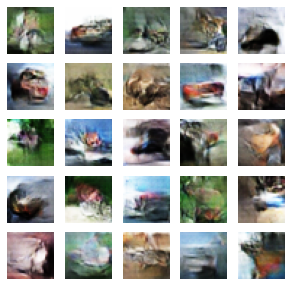

CPU times: user 44min 31s, sys: 2min 18s, total: 46min 49s
Wall time: 42min 32s


In [5]:
%%time
train(train_dataset, EPOCHS)

In [6]:
import joblib

plot_seed = tf.random.normal([25, noise_dim],seed = 1234)
joblib.dump(plot_seed,'fixed_seed.joblib')

In [7]:
generator.load_weights(os.path.join(
                    checkpoint_dir, f'epoch-1000'
                ))

predictions = generator(joblib.load('fixed_seed.joblib'), training=False)

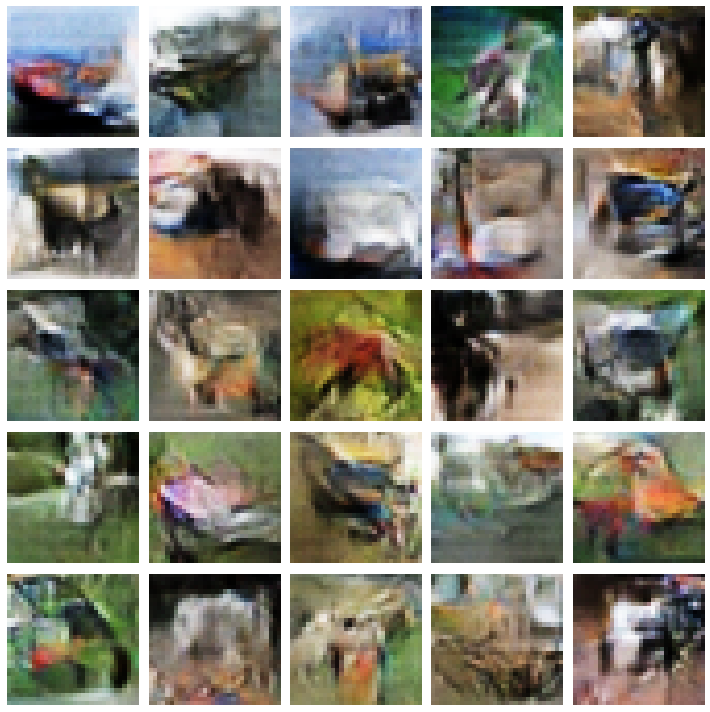

In [8]:
fig = plt.figure(figsize=(10,10))

for i in range(predictions.shape[0]):
    plt.subplot(5, 5, i+1)
    plt.imshow((predictions[i, :, :, :] + 1 ) / 2)
    plt.axis('off')
fig.tight_layout()
joblib.dump(predictions.numpy(),os.path.join(log_path,f'{log_prefix}_numpy.joblib'))
fig.savefig(os.path.join(log_path,f'{log_prefix}_image.eps'),format = 'eps')